Balance Risk Set Matching

Original Paper: https://doi.org/10.1198/016214501753208573

    Honoridez, Kyn R.
    Montebon, Al Winmon



In [38]:
# Import Required Libraries

# Import numerical and data analysis libraries
import numpy as np
import pandas as pd

# Include distance computation and utilities
from scipy.spatial.distance import cdist
from collections import defaultdict

# Add plotting capabilities
import matplotlib.pyplot as plt

## Initialization of Global Variables and Seed

In [39]:
# Initialize Global Variables & Settings

# Set the random seed for reproducibility
np.random.seed(45)

# Define the number of patients and evaluation periods
number_of_patients = 400
evaluation_years = 4
evaluation_months = evaluation_years * 12
MAX_MATCHES = 100

# Titles for data visualization
BOX_TITLES = [
    'Baseline',
    'At Treatment',
    '3 Months after Treatment',
    '6 Months after Treatment',
    'Difference (3 mos posttreatment)',
    'Difference (6 mos posttreatment)'
]

# Labels for categorizing groups
BOX_LABELS = ['Never/Later Treated', 'Treated']

## Patient Assessment 

In [40]:
# Generate Sample Patient Data

# Create synthetic baseline data for patients
baseline_data = pd.DataFrame({
    "patient_id": np.arange(0, number_of_patients),
    "pain": np.random.randint(0, 10, number_of_patients),
    "urgency": np.random.randint(0, 10, number_of_patients),
    "frequency": np.random.randint(0, 15, number_of_patients)
})

# Display the first few rows of the baseline data
baseline_data.head()

,patient_id,pain,urgency,frequency
0,0,3,4,11
1,1,0,1,12
2,2,5,7,14
3,3,3,1,12
4,4,4,6,10


## Evaluations at 3 month intervals

In [41]:
# Create synthetic evaluation data for patients at 3-month intervals
evaluation_data = pd.DataFrame()

for patient_id in range(number_of_patients):
    chosen_treatment_time = np.random.choice(list(np.arange(3, evaluation_months + 1, 3)) + [None])
    
    # Evaluate every 3 months up to 4 years
    for month in range(3, evaluation_months + 1, 3):
        pain = np.random.randint(0, 10, 1)
        urgency = np.random.randint(0, 10, 1)
        frequency = np.random.randint(0, 20, 1)
        time_since_entry = month

        if chosen_treatment_time is None or month < chosen_treatment_time:
            time_treated = None
            treated = 0
        else:
            time_treated = chosen_treatment_time
            treated = 1

        evaluation_data = pd.concat([evaluation_data, pd.DataFrame({
            'patient_id': patient_id, 
            'pain': pain, 
            'urgency': urgency, 
            'frequency': frequency, 
            'time_since_entry': time_since_entry, 
            'time_treated': time_treated, 
            'treated': treated
        })])

# Display the first few rows of the evaluation data
evaluation_data.groupby('patient_id')[['pain', 'urgency', 'frequency']].mean().head()

,pain,urgency,frequency
patient_id,,,
0,2.7500,4.500,10.6250
1,3.7500,3.750,8.3125
2,3.6250,4.625,10.6875
3,4.6875,5.375,11.2500
4,5.3125,3.500,11.5000


## Initialize risk sets

In [42]:
# Create Risk Sets

# Initialize an empty dictionary to store risk sets
risk_sets = {}

# Loop through unique treatment times, excluding missing values
for treatment_time in evaluation_data['time_treated'].dropna().unique():
    # Identify patients who started treatment at the current time point
    treated_patients = evaluation_data[
        (evaluation_data['time_since_entry'] == treatment_time) & 
        (evaluation_data['time_treated'] == treatment_time)
    ]
    
    # Identify patients who remained untreated at the same time point
    untreated_patients = evaluation_data[
        (evaluation_data['time_since_entry'] == treatment_time) & 
        (evaluation_data['treated'] == 0)
    ]

    # Store the treated and untreated groups in the dictionary
    risk_sets[treatment_time] = (treated_patients, untreated_patients)

# Display the available time points in the risk sets
risk_sets.keys()

dict_keys([21, 18, 39, 24, 36, 6, 45, 15, 30, 42, 3, 12, 48, 9, 27, 33])

## Binary variable function 

In [43]:
# Binary Variable Functions

def create_binary_variables(df, variables):
    binary_vars = defaultdict(list)
    for var in variables:
        # Compute one-third and two-thirds threshold
        lower_threshold = np.percentile(df[var], 33)
        upper_threshold = np.percentile(df[var], 67)

        # Create binary variables for lower, middle, and upper groups
        binary_lower = (df[var] <= lower_threshold).astype(int)
        binary_middle = ((df[var] > lower_threshold) & (df[var] <= upper_threshold)).astype(int)
        binary_upper = (df[var] > upper_threshold).astype(int)
        
        # Append to binary_vars "x_lower" is already implied if both variables are 0
        binary_vars[f"{var}_middle"].extend(binary_middle)
        binary_vars[f"{var}_upper"].extend(binary_upper)

    # Generate binary DataFrame for each symptom variable
    binary_df = pd.DataFrame(binary_vars)
    return binary_df

## Risk set updated

In [44]:
# Update Risk Sets with Binary Variables

# Define the variables to be used for creating binary indicators
variables = [
    'pain_current',
    'urgency_current',
    'frequency_current',
    'pain_baseline',
    'urgency_baseline',
    'frequency_baseline'
]

# Initialize a new dictionary to store updated risk sets
updated_risk_sets = {}

# Loop through each risk set and update with binary variables
for key, (treated, untreated) in risk_sets.items():
    # Merge treated patients with baseline data
    treated_patients = treated.merge(baseline_data, on='patient_id', suffixes=['_current', '_baseline'])
    
    # Generate binary variables for treated patients
    binary_treated = create_binary_variables(treated_patients, variables)
    treated_patients = pd.concat([treated_patients, binary_treated], axis=1)
    
    # Merge untreated patients with baseline data
    untreated_patients = untreated.merge(baseline_data, on='patient_id', suffixes=['_current', '_baseline'])
    
    # Generate binary variables for untreated patients
    binary_untreated = create_binary_variables(untreated_patients, variables)
    untreated_patients = pd.concat([untreated_patients, binary_untreated], axis=1)
    
    # Store the updated treated and untreated groups in the new dictionary
    updated_risk_sets[key] = (treated_patients, untreated_patients)

# Display the columns of the first updated treated group to verify the changes
list(updated_risk_sets.values())[0][0].columns

Index(['patient_id', 'pain_current', 'urgency_current', 'frequency_current',
       'time_since_entry', 'time_treated', 'treated', 'pain_baseline',
       'urgency_baseline', 'frequency_baseline', 'pain_current_middle',
       'pain_current_upper', 'urgency_current_middle', 'urgency_current_upper',
       'frequency_current_middle', 'frequency_current_upper',
       'pain_baseline_middle', 'pain_baseline_upper',
       'urgency_baseline_middle', 'urgency_baseline_upper',
       'frequency_baseline_middle', 'frequency_baseline_upper'],
      dtype='object')

## Matching Functions

Implementing matching algorithm using minimum cost flow and balanced pair approaches

### Computing for the different distance between the treated and untreated using Mahalanobis

In [45]:
# Compute Mahalanobis Distance
def compute_mahalanobis_distance(treated, untreated, covariates):
    treated_matrix = treated[covariates].to_numpy()
    untreated_matrix = untreated[covariates].to_numpy()
    
    return cdist(treated_matrix, untreated_matrix, metric='mahalanobis')

# Store distances and matches as well as average distance
distance_dict = defaultdict(list)

for key, (treated, untreated) in updated_risk_sets.items():
    distance_matrix = compute_mahalanobis_distance(treated, untreated, variables)
    
    for i, row in enumerate(distance_matrix):
        for j, distance in enumerate(row):
            distance_dict[distance].append((int(treated['patient_id'].iloc[i]), int(untreated['patient_id'].iloc[j])))

average_distance = sum(distance_dict.keys()) / len(distance_dict.keys())


In [46]:
# Create matches from Minimum Cost Flow in a Network (top 100)
mcf_matches = []  # Minimum Cost Flow matches
count = 0

for keys in sorted(distance_dict.keys()):
    for match in distance_dict[keys]:
        if count >= MAX_MATCHES:
            break
            
        mcf_matches.append(match)
        count += 1

# Compute sum of K binary variables
def find_sum_bin(series, variables):
    total = 0

    # This way lower = 0, middle = 1, upper = 2
    for i, var in enumerate(variables):
        total += (i + 1) * series.loc[var]

    return total

In [47]:
# Balanced Pair Matching
bpm_matches = []
patient_set = set()
count = 0

binary_vars = [
    f"{x}_middle" for x in variables
] + [
    f"{x}_upper" for x in variables
]

for (treated, untreated) in updated_risk_sets.values():
    for i in range(treated.shape[0]):
        for j in range(untreated.shape[0]):
            # If balanced
            if count < MAX_MATCHES and find_sum_bin(treated.iloc[i], binary_vars) == find_sum_bin(untreated.iloc[j], binary_vars):
                treated_id = int(treated['patient_id'].iloc[i])
                untreated_id = int(untreated['patient_id'].iloc[j])

                if treated_id not in patient_set and untreated_id not in patient_set: 
                    bpm_matches.append((treated_id, untreated_id))
                    
                    patient_set.add(treated_id)
                    patient_set.add(untreated_id)
                    count += 1


## Grouping of Data Frames(basing from the matches)

In [48]:
# Group DataFrames based on matches
def find_dataframes(match):
    x, y = match
    features = ['pain', 'urgency', 'frequency']

    # Getting baseline data
    baseline_match_x = baseline_data[baseline_data['patient_id'] == x][features]
    baseline_match_y = baseline_data[baseline_data['patient_id'] == y][features]

    features.append('treated')
    
    # Getting on treatment data
    treatment_match_x = evaluation_data[(evaluation_data['patient_id'] == x) 
        & (evaluation_data['time_treated'] == evaluation_data['time_since_entry'])][features + ['time_since_entry']]

    time_since_entry = treatment_match_x['time_since_entry'].iloc[0] if not treatment_match_x['time_since_entry'].empty else -1
    
    if time_since_entry == -1:
        return ()
    else:
        treatment_match_x = treatment_match_x.drop('time_since_entry', axis=1)

    treatment_match_y = evaluation_data[(evaluation_data['patient_id'] == y) 
        & (evaluation_data['time_since_entry'] == time_since_entry)][features]

    # Getting 3 months after data
    time_since_entry += 3
    
    _3_months_match_x = evaluation_data[(evaluation_data['patient_id'] == x) 
        & (evaluation_data['time_since_entry'] == time_since_entry)][features]
    _3_months_match_y = evaluation_data[(evaluation_data['patient_id'] == y) 
        & (evaluation_data['time_since_entry'] == time_since_entry)][features]

    # Getting 6 months after data
    time_since_entry += 3

    _6_months_match_x = evaluation_data[(evaluation_data['patient_id'] == x) 
        & (evaluation_data['time_since_entry'] == time_since_entry)][features]
    _6_months_match_y = evaluation_data[(evaluation_data['patient_id'] == y) 
        & (evaluation_data['time_since_entry'] == time_since_entry)][features]

    return (
        baseline_match_x, 
        baseline_match_y,
        treatment_match_x,
        treatment_match_y,
        _3_months_match_x,
        _3_months_match_y,
        _6_months_match_x,
        _6_months_match_y
    )

In [49]:
# Initializing DataFrames
dataframes = [pd.DataFrame() for _ in range(12)]

treatment_index = 2
month_index = 4

for match in bpm_matches:
    data = find_dataframes(match)

    if len(data) == 0:
        continue

    for i in range(len(dataframes) - 4):  # minus 4 to remove last 2 box plots
        dataframes[i] = pd.concat([dataframes[i], data[i]])

    for i in range(4):
        index = len(dataframes) - 4 + i
        dataframes[index] = pd.concat([dataframes[index], data[month_index + i] - data[treatment_index + (i // 2)]])

for index in range(len(dataframes)):
    dataframes[index] = dataframes[index].dropna()

# Analysys & Visualization
Creates visualization and analyze matched pairs.

In [50]:
# Analysis & Visualization

def display_boxplots(column, title):
    global dataframes
    
    # Create the necessary subplots (adjust number of rows and columns based on data)
    num_rows = len(dataframes) // 4
    fig, axes = plt.subplots(num_rows, 2, figsize=(10, 5 * num_rows))
    
    # Flatten the axes for easy indexing
    axes = axes.flatten()

    box_titles = [
        'Baseline',
        'At Treatment',
        '3 Months after Treatment',
        '6 Months after Treatment',
        'Difference (3 mos posttreatment)',
        'Difference (6 mos posttreatment)'
    ]

    # Iterate through each dataframe pair (i.e., treatment vs. control)
    for i in range(0, len(dataframes), 2):    
        # Skip if the current dataframe is empty
        if dataframes[i].empty or dataframes[i+1].empty:
            continue
        
        # Plot boxplot on corresponding subplot axes
        axes[i // 2].boxplot([dataframes[i][column].dropna(), dataframes[i + 1][column].dropna()], widths=0.5)
        
        # Set titles and labels
        axes[i // 2].set_title(box_titles[i // 2])
        axes[i // 2].set_ylabel(title)
        axes[i // 2].set_xticklabels(['Never/Later Treated', 'Treatment'])  # Customize the x-axis labels

    # Adjust space between subplots for better layout
    plt.subplots_adjust(
        wspace=0.5,
        hspace=0.5
    )

    # Show the plots
    plt.show()

# Pain Score Analysis

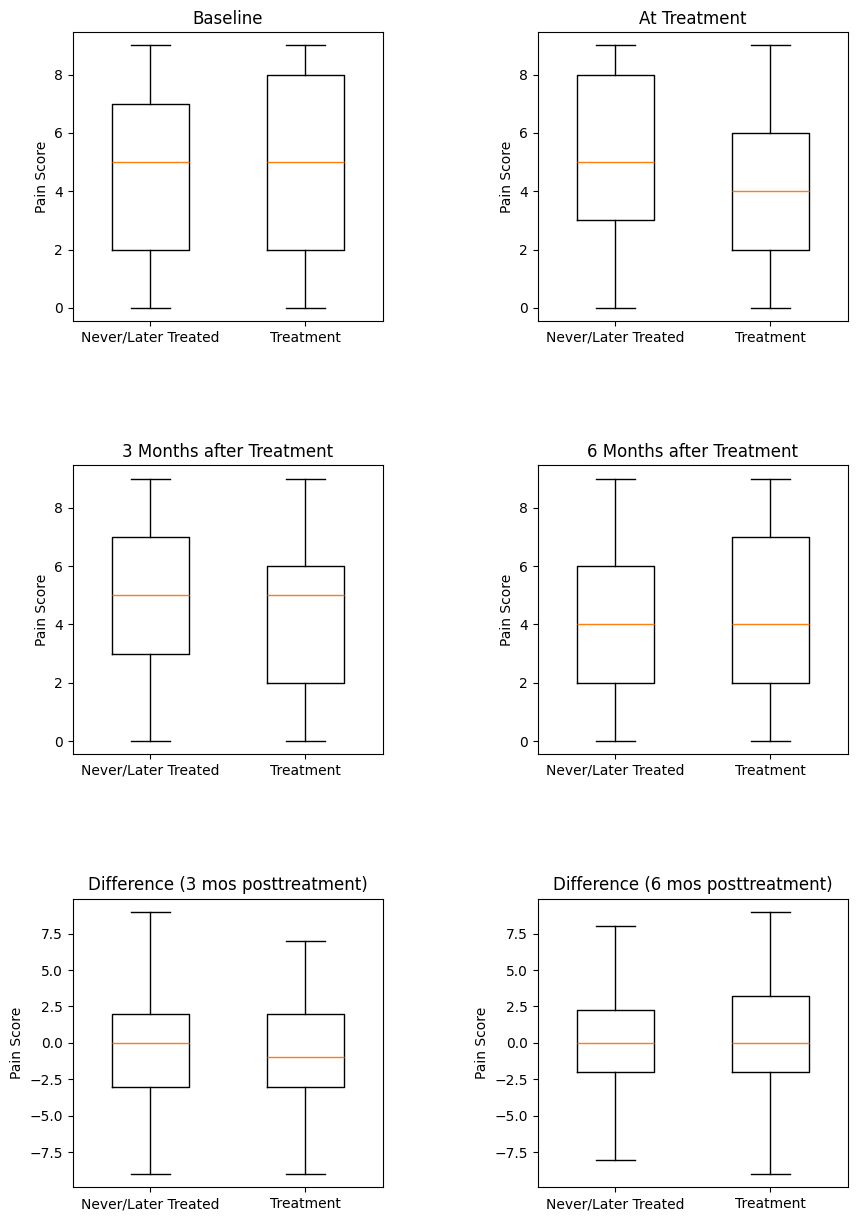

In [51]:
display_boxplots('pain', 'Pain Score')

# Urgency Score Analysis

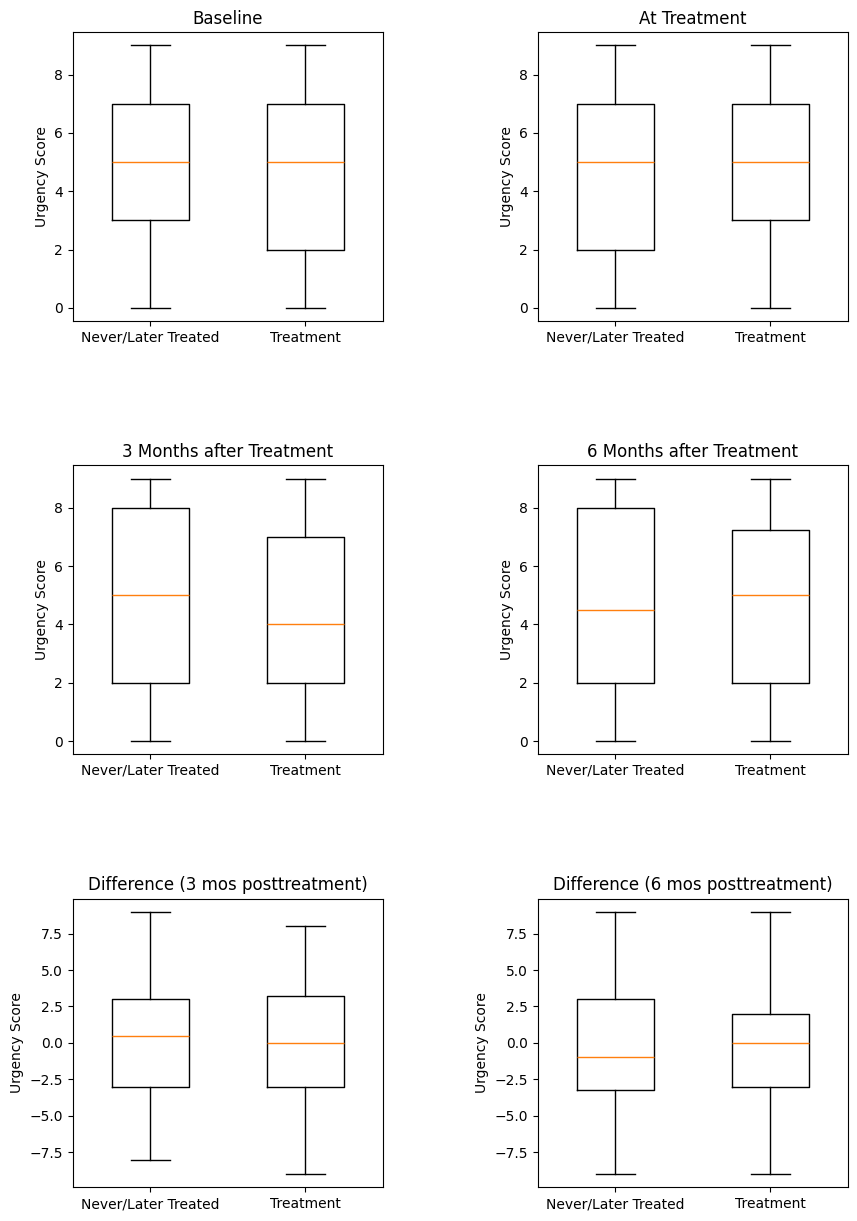

In [36]:
display_boxplots('urgency', 'Urgency Score')

# Nocturnal Frequency

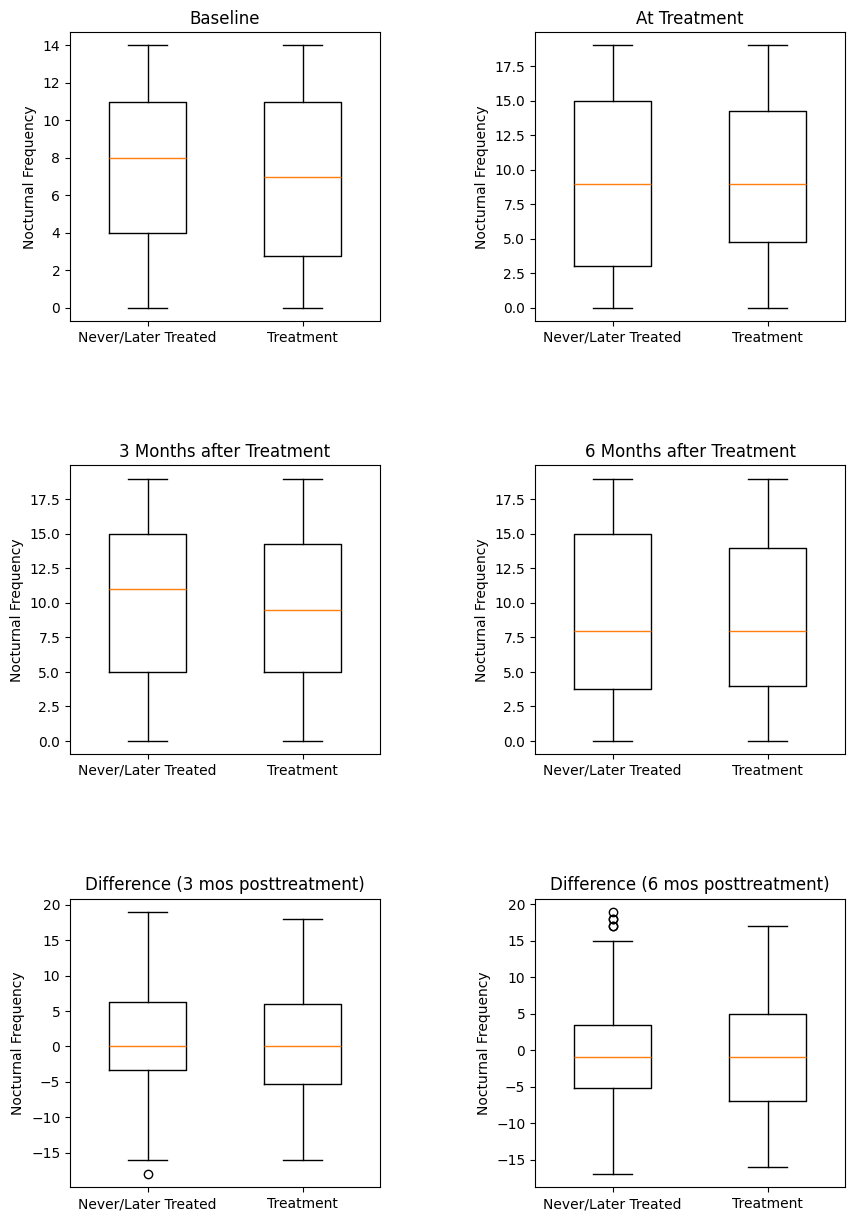

In [37]:
display_boxplots('frequency', 'Nocturnal Frequency')